In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score
import shutil
import random
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
# Define paths
base_dir = r"Path to Dataset"
# Create New folder Data_Split
output_dir = r"Path to Data_Split folder"
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
target_size = (256, 256) 

In [10]:
# Function to resize the existing image in place

def resize_in_place(image_path, target_size):
    with Image.open(image_path) as img:
        img = img.convert("RGB") 

        img.thumbnail(target_size)

        new_img = Image.new("RGB", target_size, (128, 128, 128))
        paste_position = ((target_size[0] - img.size[0]) // 2, (target_size[1] - img.size[1]) // 2)
        new_img.paste(img, paste_position)

        new_img.save(image_path)

In [11]:
# Resize all images in place

for animal in os.listdir(base_dir):
    animal_dir = os.path.join(base_dir, animal)
    images = [img for img in os.listdir(animal_dir) if img.endswith(('.jpg', '.png'))]

    for img in images:
        img_path = os.path.join(animal_dir, img)
        resize_in_place(img_path, target_size)

# Splitting
for split in ["train", "val", "test"]:
    for animal in os.listdir(base_dir):
        os.makedirs(os.path.join(output_dir, split, animal), exist_ok=True)

for animal in os.listdir(base_dir):
    animal_dir = os.path.join(base_dir, animal)
    images = [img for img in os.listdir(animal_dir) if img.endswith(('.jpg', '.png'))]

    random.shuffle(images)

    total_images = len(images)
    train_size = int(total_images * train_ratio)
    val_size = int(total_images * val_ratio)

    train_images = images[:train_size]
    val_images = images[train_size:train_size + val_size]
    test_images = images[train_size + val_size:]

    for img in train_images:
        shutil.copy(os.path.join(animal_dir, img), os.path.join(output_dir, "train", animal, img))

    for img in val_images:
        shutil.copy(os.path.join(animal_dir, img), os.path.join(output_dir, "val", animal, img))

    for img in test_images:
        shutil.copy(os.path.join(animal_dir, img), os.path.join(output_dir, "test", animal, img))

print("Dataset resized and split completed successfully!")

Dataset resized and split completed successfully!


In [ ]:
dataset_dir = r"Path to Data_Split"

# Data Augmentation & Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
img_size = (256, 256)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2800 images belonging to 4 classes.
Found 600 images belonging to 4 classes.
Found 600 images belonging to 4 classes.


In [ ]:
# # Checking the number of images for each class

# class_indices = train_generator.class_indices
# num_images_per_class = {class_name: 0 for class_name in class_indices}

# for i in range(len(train_generator)):
#     batch_images, batch_labels = train_generator[i]
#     for label in batch_labels:
#         class_index = label.argmax()
#         class_name = list(class_indices.keys())[class_index]
#         num_images_per_class[class_name] += 1

# for class_name, count in num_images_per_class.items():
#     print(f"{class_name}: {count} images")

In [12]:
# CNN Model

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [14]:
# Model fitting

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, lr_scheduler]
)

c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 78s 874ms/step - accuracy: 0.3247 - loss: 2.2373 - val_accuracy: 0.5633 - val_loss: 0.9181 - learning_rate: 0.0010
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 54s 616ms/step - accuracy: 0.5665 - loss: 0.9145 - val_accuracy: 0.6083 - val_loss: 0.9973 - learning_rate: 0.0010
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 53s 600ms/step - accuracy: 0.6537 - loss: 0.8367 - val_accuracy: 0.6650 - val_loss: 0.8195 - learning_rate: 0.0010
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 53s 600ms/step - accuracy: 0.7106 - loss: 0.7333 - val_accuracy: 0.7250 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 53s 603ms/step - accuracy: 0.7095 - loss: 0.6915 - val_accuracy: 0.7033 - val_loss: 0.8591 - learning_rate: 0.0010
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 54s 608ms/step - accuracy: 0.7432 - loss: 0.6451 - val_accuracy: 0.7633 - val_loss: 0.6152 - learning_rate: 0.0010
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 57s 647ms/step - accuracy: 0.7304 - loss: 0.

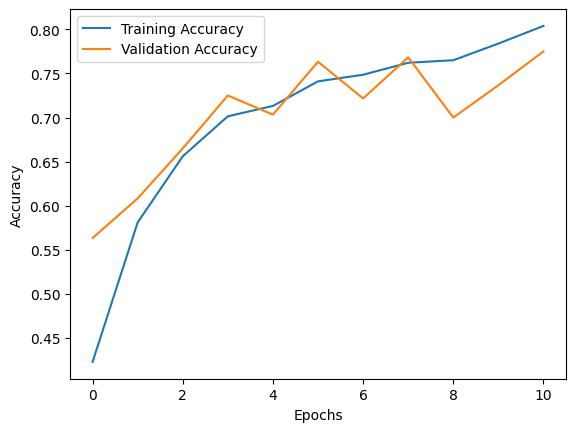

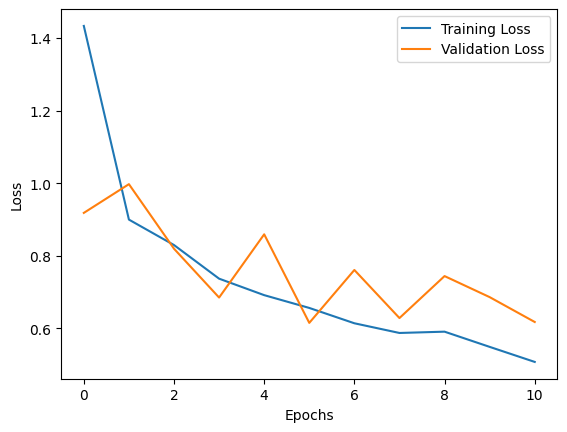

In [15]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
model.save("animal_classifier_model_final.h5")
print("Model saved successfully!")

Model saved successfully!


In [17]:
# Function to generate report

def generate_classification_report(model, generator):
    y_true = []
    y_pred = []
    class_labels = list(train_generator.class_indices.keys())

    for _ in range(len(generator)):
        x_batch, y_batch = next(iter(generator))
        predictions = model.predict(x_batch)

        y_true.extend(np.argmax(y_batch, axis=1))
        y_pred.extend(np.argmax(predictions, axis=1))

    report = classification_report(y_true, y_pred, target_names=class_labels)
    print("Classification Report:\n", report)

generate_classification_report(model, val_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Classification Report:
               precision    recall  f1-score   support

     Buffalo       0.79      0.77      0.78       150
    Elephant       0.67      0.61      0.64       150
       Rhino       0.70      0.72      0.71       150
       Zebra      

In [18]:
generate_classification_report(model, test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Classification Report:
               precision    recall  f1-score   support

     Buffalo       0.78      0.74      0.76       150
    Elephant       0.68      0.68      0.68       150
       Rhino       0.69      0.65      0.67       150
       Zebra       

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(r"Path to saved model")

In [6]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.7871 - loss: 0.5440
Test Loss: 0.6212334036827087
Test Accuracy: 0.7599999904632568


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


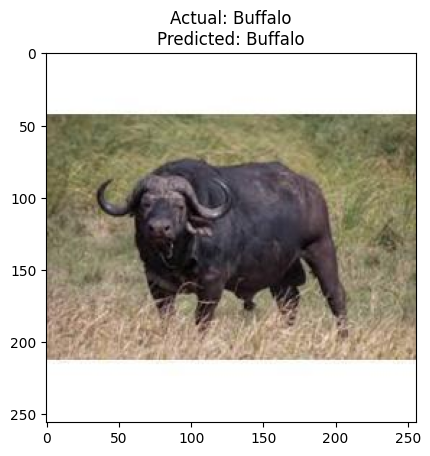

In [43]:

x_batch, y_batch = next(test_generator)

image = x_batch[0]
actual_label = np.argmax(y_batch[0])

prediction = model.predict(np.expand_dims(image, axis=0))
predicted_label = np.argmax(prediction)

class_labels = list(train_generator.class_indices.keys())

plt.imshow(image)
# plt.axis("off")
plt.title(f"Actual: {class_labels[actual_label]}\nPredicted: {class_labels[predicted_label]}")
plt.show()


In [ ]:
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array)
    class_labels = list(train_generator.class_indices.keys())
    
    predicted_class = class_labels[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")

predict_image(r"path")